In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

import utils.datasets_utils as datasets_utils
import utils.classification_utils as classification_utils

sns.set_palette("Set2")
sns.set_style("whitegrid")

# CHANGE RESULTS SHOWNIG DF. CHANGE LABEL ENCODING STUFFF

In [3]:
datasets = datasets_utils.load_datasets()
datasets_wrapper = datasets_utils.DatasetsWrapper(datasets)

In [4]:
datasets_wrapper.get_shapes()

,train_X,val_X,test_X,train_y,val_y,test_y
spectral_original,"(21572, 189)","(2397, 189)","(5993, 189)","(21572,)","(2397,)","(5993,)"
all_original,"(21572, 287)","(2397, 287)","(5993, 287)","(21572,)","(2397,)","(5993,)"
pca_original,"(21572, 138)","(2397, 138)","(5993, 138)","(21572,)","(2397,)","(5993,)"
umap_original,"(21572, 15)","(2397, 15)","(5993, 15)","(21572,)","(2397,)","(5993,)"
spectral_modified,"(23114, 189)","(2397, 189)","(5993, 189)","(23114,)","(2397,)","(5993,)"
all_modified,"(23114, 287)","(2397, 287)","(5993, 287)","(23114,)","(2397,)","(5993,)"
pca_modified,"(23114, 136)","(2397, 136)","(5993, 136)","(23114,)","(2397,)","(5993,)"
umap_modified,"(23114, 15)","(2397, 15)","(5993, 15)","(23114,)","(2397,)","(5993,)"


In [5]:
label_encoder = LabelEncoder()
datasets_wrapper.encode_labels(encoder=label_encoder)

Scaling helps convergence for logistic regression

In [6]:
scaler = StandardScaler()
datasets_wrapper.scale_datasets(scaler)

# 1. Training

In [7]:
classifiers = [classification_utils.ClassifierFactory.create_instance(
    dataset=dataset, 
    classifier=LogisticRegression(multi_class='multinomial', solver='sag', random_state=123, max_iter=500),
    encoder=label_encoder,
) for dataset in datasets]

In [8]:
cl_collection = classification_utils.ClassifiersCollection(classifiers)

In [9]:
cl_collection.fit_classifiers()

Fitting classifiers...


  0%|          | 0/8 [00:00<?, ?it/s]d:\Kiril\Da Finki\6 Semestar\Податочно Рударење\PR_Labs\clone\Music-Genre-Classification\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▎        | 1/8 [01:09<08:05, 69.32s/it]d:\Kiril\Da Finki\6 Semestar\Податочно Рударење\PR_Labs\clone\Music-Genre-Classification\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 2/8 [02:54<09:02, 90.35s/it]d:\Kiril\Da Finki\6 Semestar\Податочно Рударење\PR_Labs\clone\Music-Genre-Classification\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 4/8 [03:50<03:01, 45.45s/it]d:\Kiril\Da Finki\6 Semestar\Податочно Рударење\PR_Labs\clone\Music-Genre-Classifica

Done


In [10]:
datasets_wrapper.reverse_encode_labels()

# 2. Results

In [ ]:
evaluation_df = cl_collection.evaluate_classifiers()

In [ ]:
evaluation_df[[dataset.name for dataset in datasets if 'original' in dataset.name]]

In [ ]:
evaluation_df[[dataset.name for dataset in datasets if 'modified' in dataset.name]]

- All Original

In [12]:
all_original_classifier = cl_collection.get_classifier('all_original')

In [13]:
all_original_classifier.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.660949,0.638715,0.634407
precision (weighted),0.642603,0.620382,0.607442
recall (weighted),0.660949,0.638715,0.634407
f1 (weighted),0.640754,0.617852,0.612338


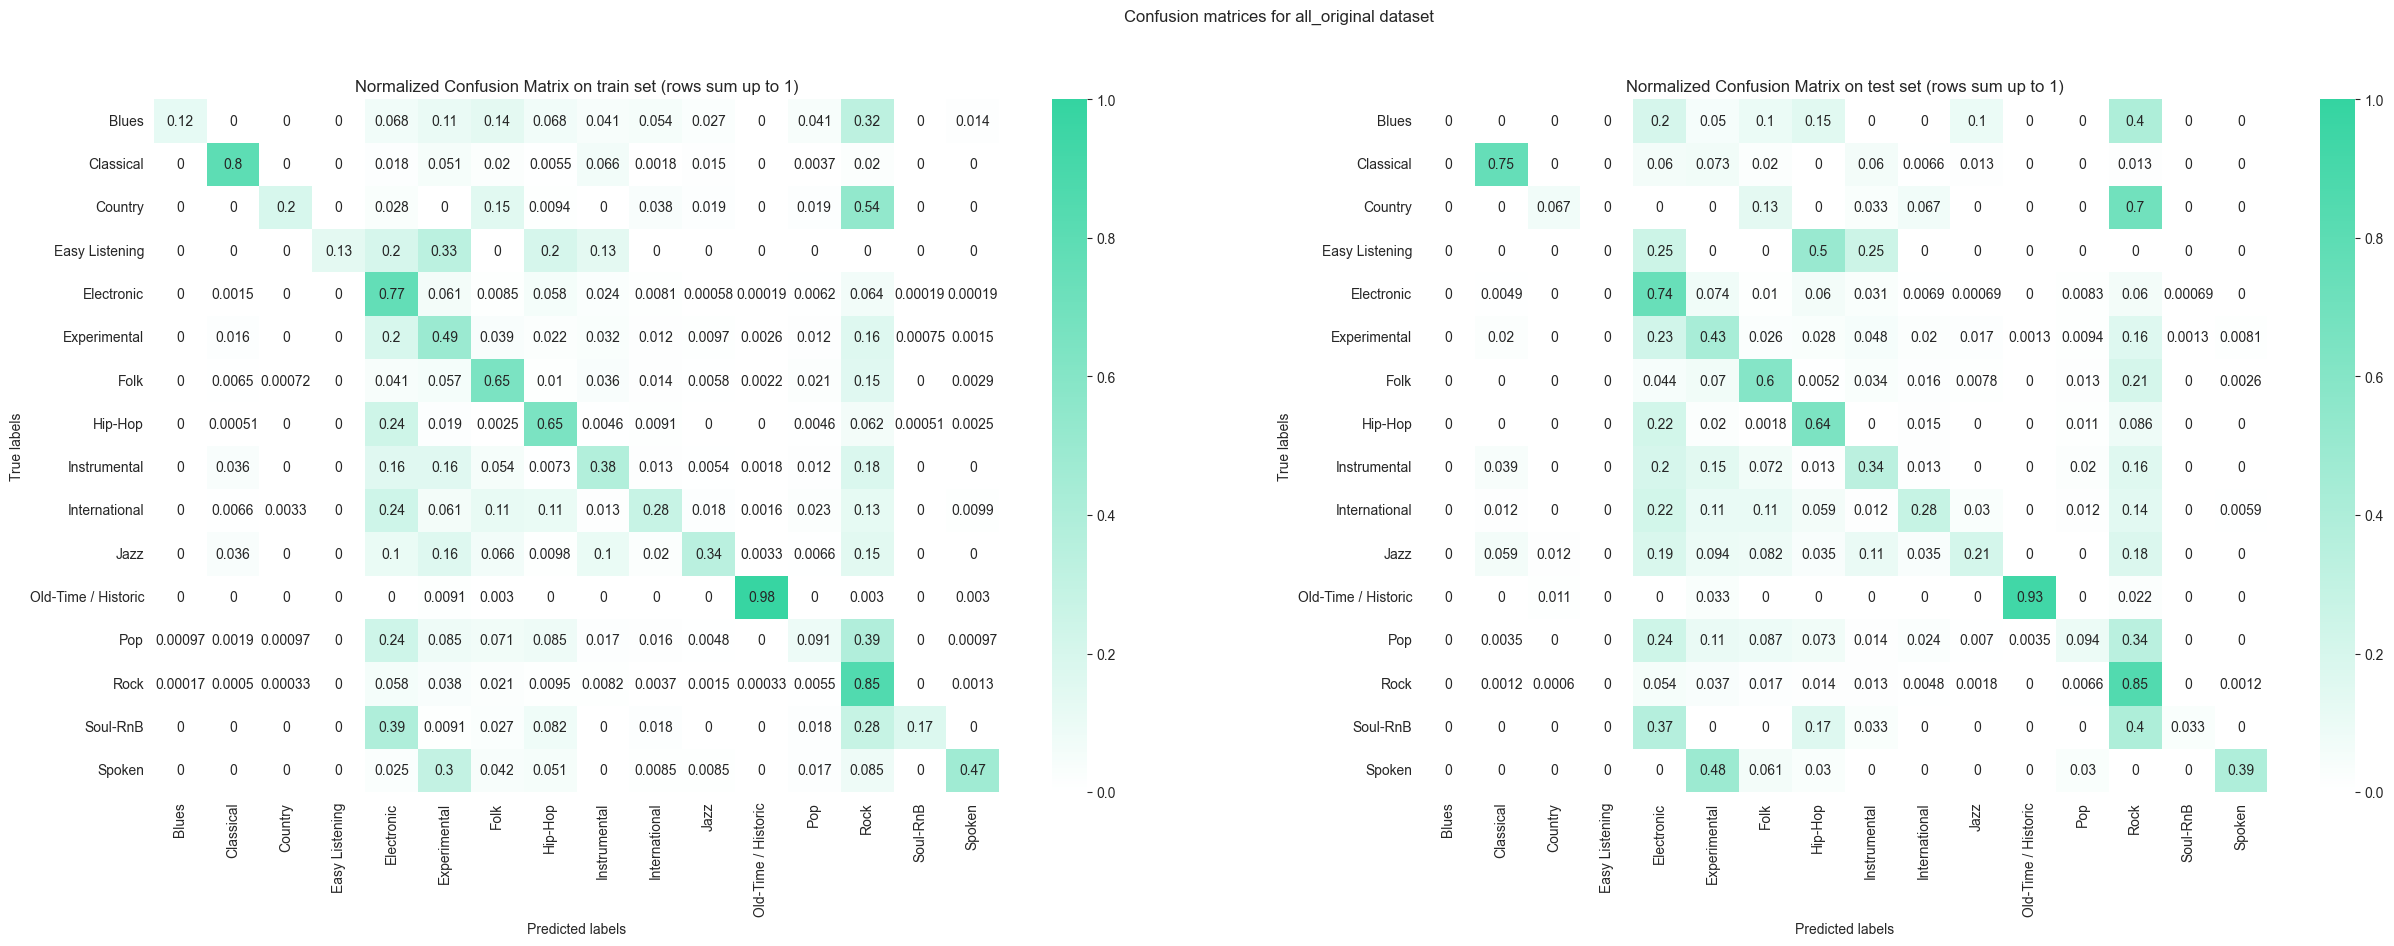

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
all_original_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
all_original_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('Confusion matrices for all_original dataset')
plt.show()

Metrics on train set

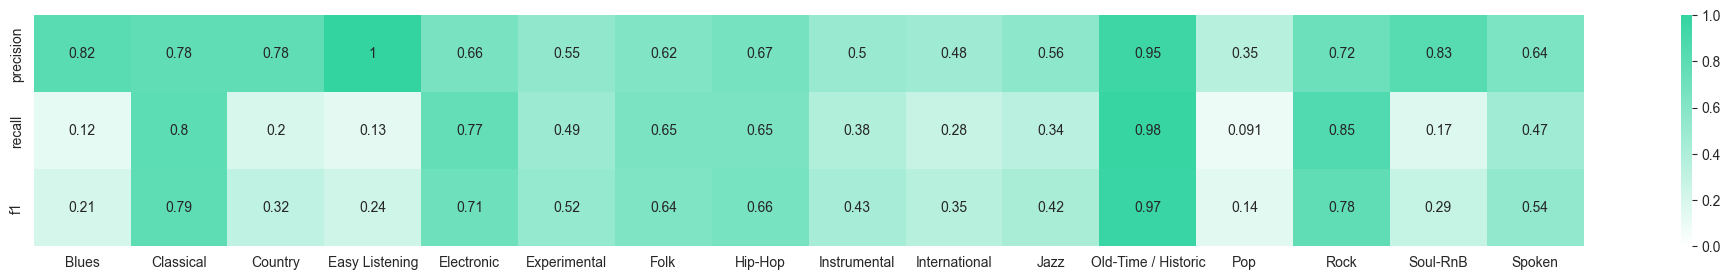

In [15]:
_, ax = plt.subplots(1, 1, figsize=(25, 3))
all_original_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax, on_set='train')
plt.show()

Metrics on test set

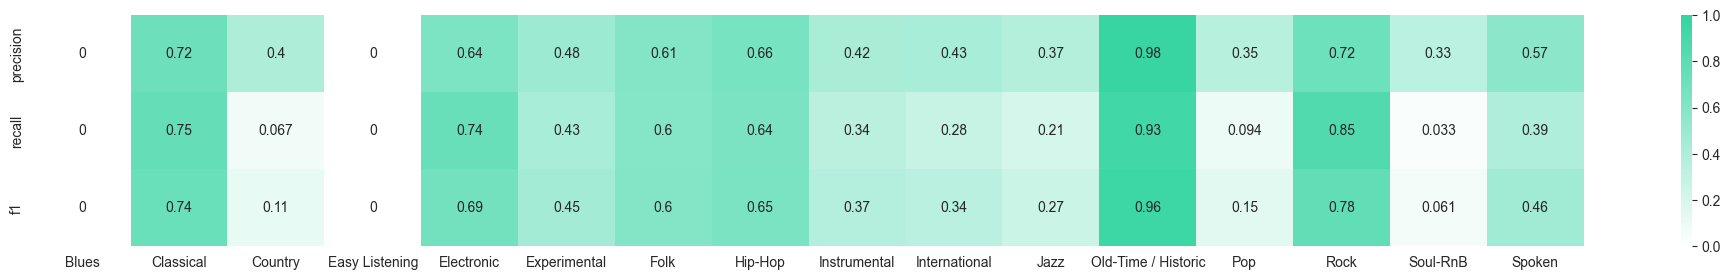

In [16]:
_, ax = plt.subplots(1, 1, figsize=(25, 3))
all_original_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax, on_set='test')
plt.show()

# 3. Model Confidence

In [17]:
clf = all_original_classifier.classifier
test_X = all_original_classifier.dataset.test.X
test_y = all_original_classifier.dataset.test.y

predicted_proba = pd.DataFrame(clf.predict_proba(test_X), columns=sorted(test_y.unique().tolist()), index=test_X.index)

# For each row, assign the column whose value for the predicted probability is the highest
predicted_proba['genre'] = predicted_proba.idxmax(axis=1)

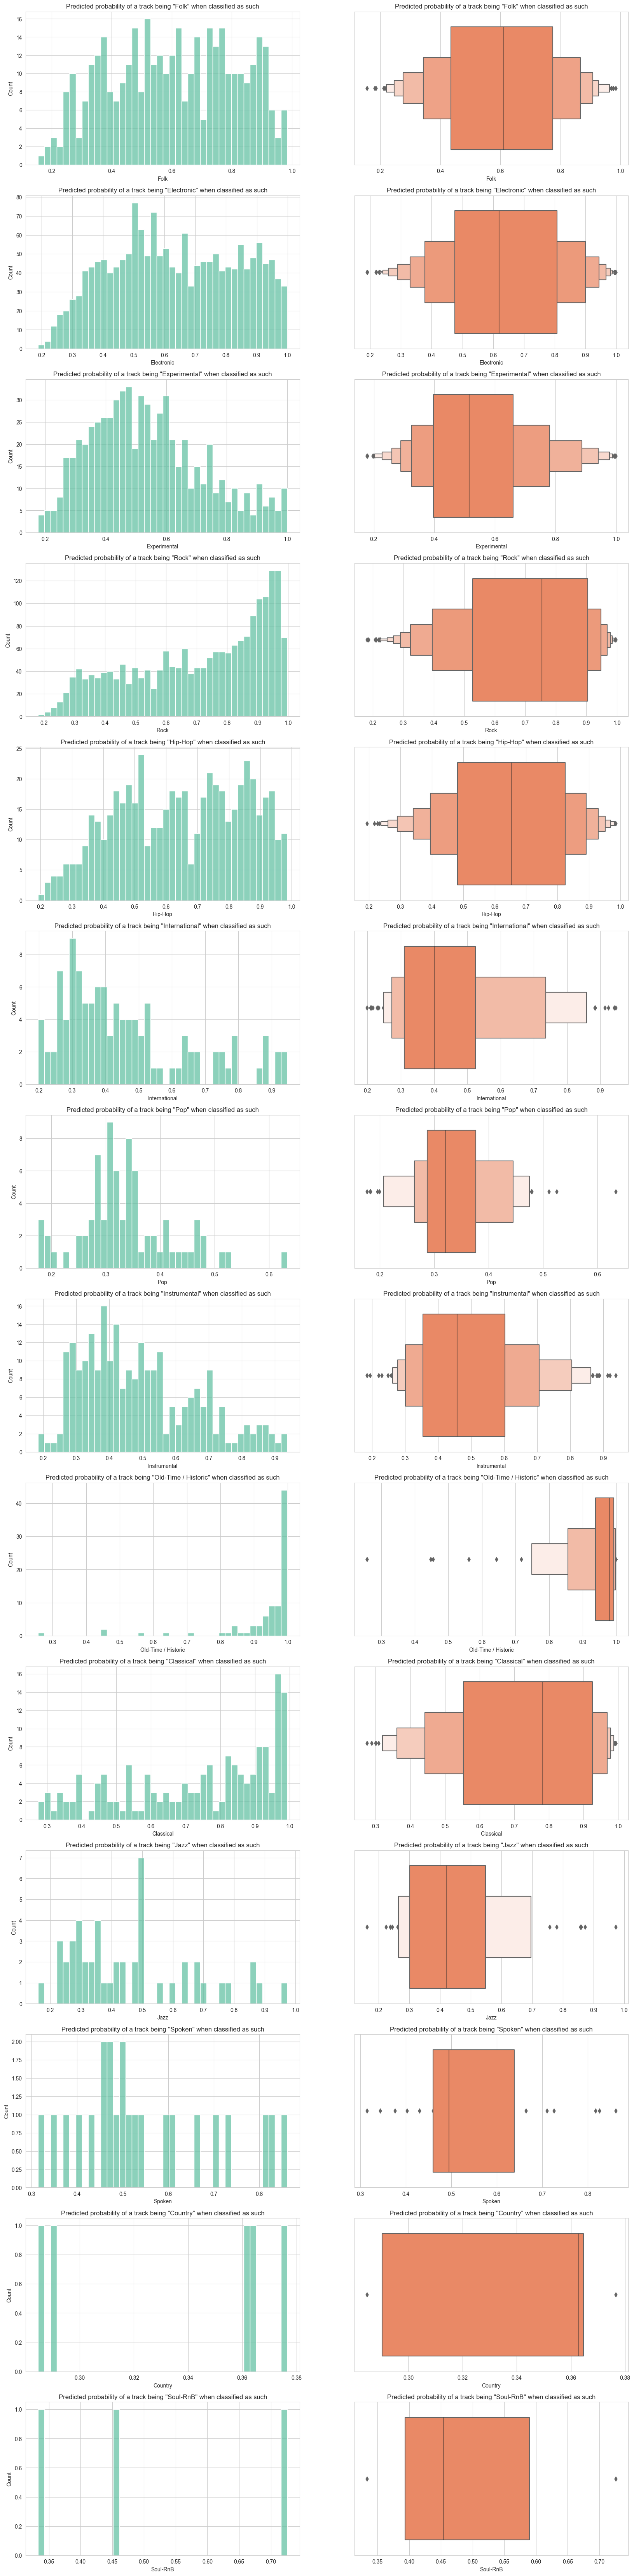

In [18]:
num_genres = predicted_proba['genre'].nunique()
ax_idxs = [(i, j) for i in range(num_genres) for j in range(2)]

fig, axs = plt.subplots(num_genres, 2, figsize=(20, 85))

k = 0
for genre in predicted_proba['genre'].unique():
    ax1_idx, ax2_idx = ax_idxs[k], ax_idxs[k + 1]
    ax1, ax2 = axs[ax1_idx[0]][ax1_idx[1]], axs[ax2_idx[0]][ax2_idx[1]]

    ax1.set_title(f'Predicted probability of a track being "{genre}" when classified as such')
    ax2.set_title(f'Predicted probability of a track being "{genre}" when classified as such')

    sns.histplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], bins=40, ax=ax1)
    sns.boxenplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], color='coral', ax=ax2)
    k += 2